In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir


In [15]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [16]:
animal, sess_name = 'Finn2', 'habituation1'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data3/Trace_FC/Recording_Rats/Finn2/2023_05_06_habituation1/Finn2_habituation1_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [17]:
print(sess.eegfile)

duration: 2810.66 seconds 
duration: 0.78 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [65]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=8, 
                                    edge_cutoff=4, merge=6)

    # Code to add in artifact epochs manually - comment out after using
    # art_epochs = art_epochs.add_epoch_manually(538, 560)
    # art_epochs = art_epochs.add_epoch_manually(1588, 1615)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs

Buffer of 0.25 added before/after each epoch
/data3/Trace_FC/Recording_Rats/Finn2/2023_05_06_habituation1/Finn2_habituation1_denoised.art_epochs.npy saved
Total artifact time = 18.6 seconds


11 epochs
Snippet: 
        start       stop label
0  1189.1780  1189.7036      
1  1223.5540  1228.7172      
2  1713.7444  1714.2732      
3  1797.3420  1798.3564      
4  1878.0644  1878.8980      

<Axes: >

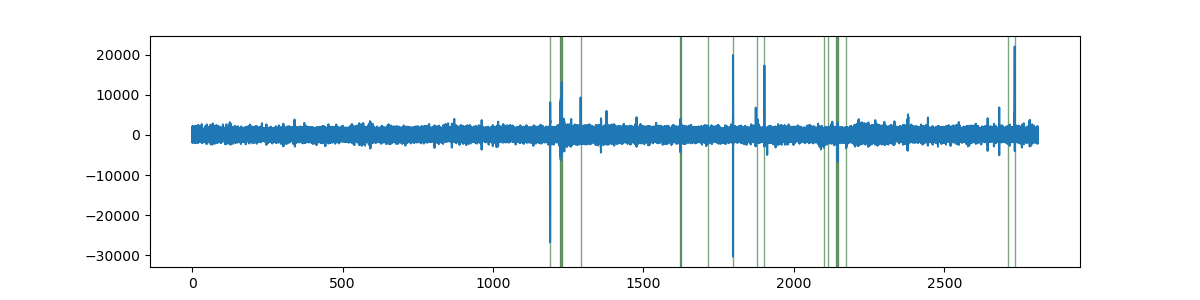

In [83]:
%matplotlib widget

chan_plot = 4
plot_signal_w_epochs(signal, chan_plot, art_epochs)

In [82]:
# Add in epochs manually after inspection in neuroscope - then re-run above to check!
epochs_to_add =np.array([[1291, 1291.2], [2734, 2734.5], [1622, 1623.4]])
art_epochs = art_epochs.add_epoch_manually(epochs_to_add[:, 0], epochs_to_add[:, 1])
sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
art_epochs.save(art_epochs_file)

/data3/Trace_FC/Recording_Rats/Finn2/2023_05_06_habituation1/Finn2_habituation1_denoised.art_epochs.npy saved


## Define probe group

/data3/Trace_FC/Recording_Rats/Finn2/2023_05_06_habituation1/Finn2_habituation1_denoised.probegroup.npy saved


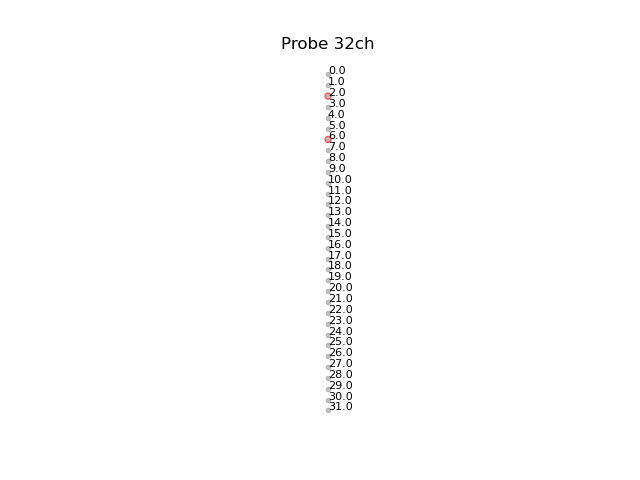

In [85]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=20, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [86]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=0.25
maxdur=20
thresh = (0.5, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 7

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')

Best channel for theta: [7]
1364 epochs remaining with durations within (0.25,20)


## Detect SWR Epochs

In [89]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 8
thresh = (2, None)  # conservative but good
exclude_theta_epochs = True  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')

Selected channels for ripples: [8]
1258 epochs remaining with durations within (0.05,0.45)


### Note that SWR detection is not that great for this session - cross-validate with PBEs if possible!

# Wavelet Analysis

### Start with Theta

In [90]:
# Run wavelet on theta range
theta_range = np.arange(4, 14, 0.25)  # How do I select these? 0.25Hz seems good to start
wv_theta = WaveletSg(signal.time_slice(channel_id=theta_channel), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

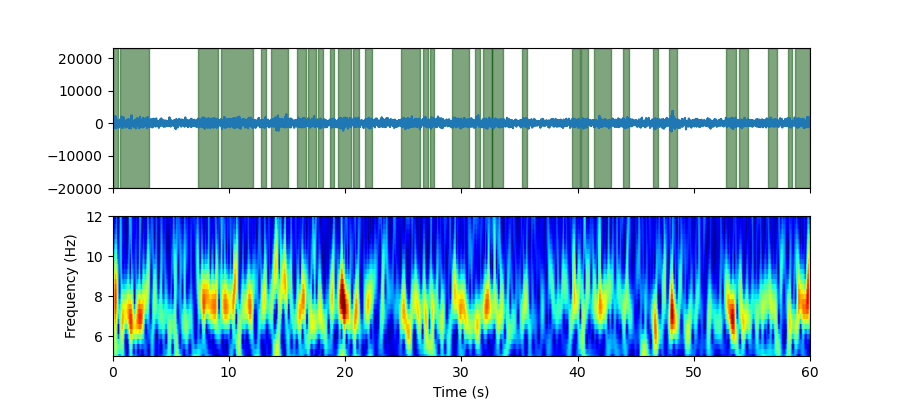

In [91]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
theta_freq_lims = [5, 12]

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

plot_spectrogram(wv_theta, time_lims=time_to_plot, freq_lims=theta_freq_lims, ax=ax[1])

### Mean spectrogram at theta starts

Events [   0    1 1362 1363] are outside of data range and were dropped


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

Text(0.5, 0, 'Time from Theta epoch start (sec)')

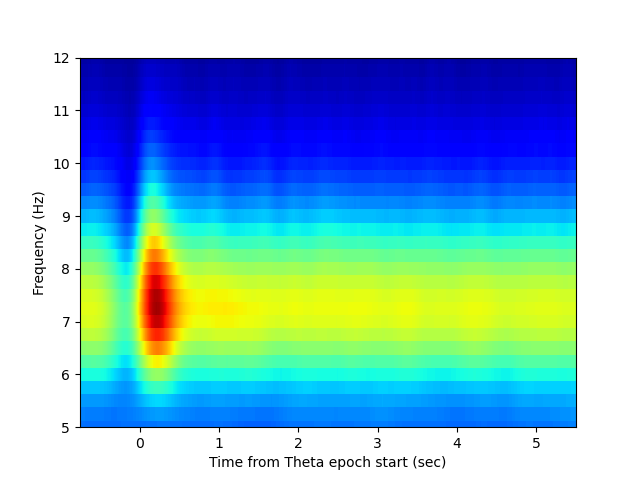

In [92]:
theta_buffer_sec = (0.75, 5.5)
wv_theta_mean = wv_theta.get_pe_mean_spec(theta_epochs.starts, buffer_sec=theta_buffer_sec)
ax = plot_spectrogram(wv_theta_mean, time_lims=np.multiply(theta_buffer_sec, (-1, 1)), freq_lims=theta_freq_lims)
ax.set_xlabel('Time from Theta epoch start (sec)')

### Try out SWRs

In [93]:
swr_range = np.arange(125, 275, 5)
wv_swr = WaveletSg(signal.time_slice(channel_id=ripple_channel), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

<Axes: xlabel='Time (s)', ylabel='Frequency (Hz)'>

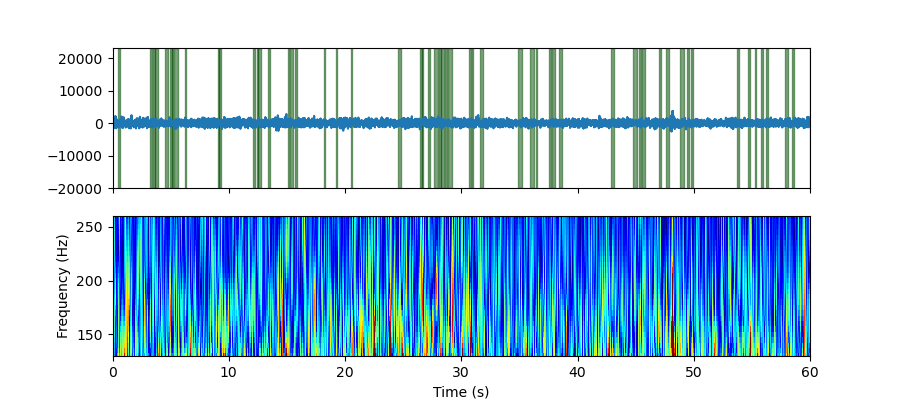

In [94]:
# Sanity check code - does wavelet align well with actual theta epochs?
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))
time_to_plot = [0, 60]
swr_freq_lims = [130, 260]

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

plot_spectrogram(wv_swr, time_lims=time_to_plot, freq_lims=swr_freq_lims, ax=ax[1])

### Mean spectrogram at all ripples

Events [1257] are outside of data range and were dropped


/data/GitHub/NeuroPy/neuropy/plotting/signals.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(1, 1)


interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

Text(0.5, 0, 'Time from Ripple Peak (sec)')

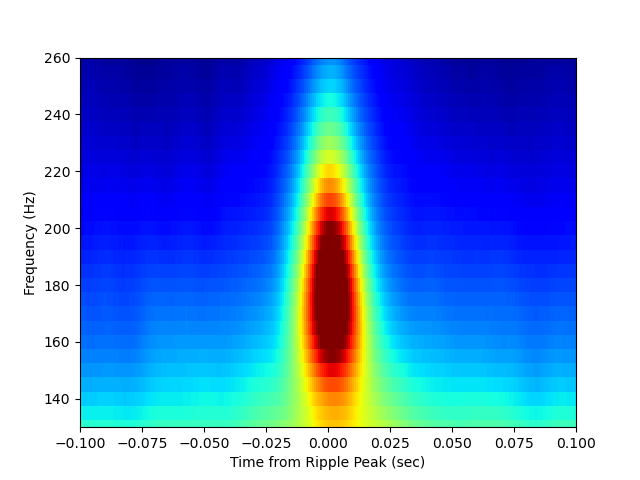

In [95]:
ripple_buffer_sec = (0.1, 0.1)
wv_swr_mean = wv_swr.get_pe_mean_spec(ripple_epochs.to_dataframe()['peak_time'].values, buffer_sec=ripple_buffer_sec)
ax = plot_spectrogram(wv_swr_mean, time_lims=np.multiply(ripple_buffer_sec, (-1, 1)), freq_lims=swr_freq_lims)
ax.set_xlabel('Time from Ripple Peak (sec)')

## Peri-CS analyses

,channel_states,timestamps,datetimes,event_name
914,2,2709318,2023-05-06 12:11:15.310600000,
1062,-2,3006823,2023-05-06 12:11:25.227433333,
1921,2,4742125,2023-05-06 12:12:23.070833333,
2070,-2,5040206,2023-05-06 12:12:33.006866667,
2869,2,6653639,2023-05-06 12:13:26.787966667,


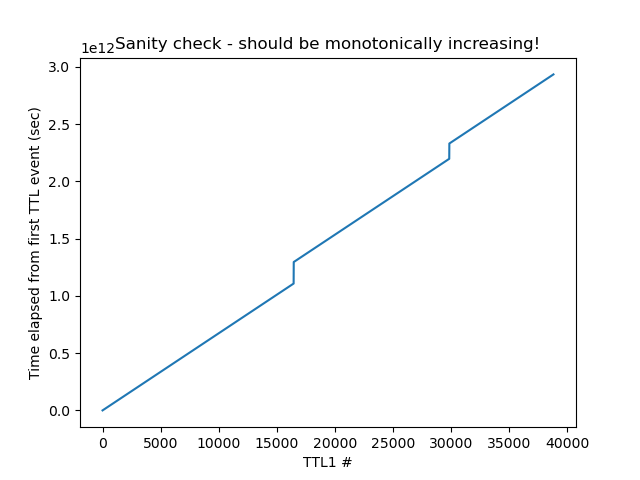

In [96]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, sanity_check_channel=1, zero_timestamps=True)
ttl_df[ttl_df['channel_states'].abs() == 2].head(5)

In [107]:
import tracefc.io.traceio as traceio

process_csn, process_cs, process_cs2 = True, True, True  # set flags for running code below
if sess_name.find("recall") == 0:
    # For tone recall CS+
    cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected during {sess_name} tone recall')
    print(cs_starts.head(6))
    
    # For control tone recall CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} control tone recall')
    print(csn_starts.head(6))
    
    # For CS+ at end of control_tone_recall
    cs2_starts, cs2_ends, cs2_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs2_starts.shape[0]} CS+ events detected during {sess_name} control tone recall')
    print(cs2_starts.head(6))
elif sess_name.find("habituation") == 0:
    # For control tone habituation CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} tone habituation')
    print(csn_starts.head(6))

    process_cs, process_cs2 = False, False
    
elif sess_name.find("training") == 0:
    # For control tone habituation CS-
    csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="tone_habituation", 
                                                          event_type="CS-", return_df=True)
    print(f'{csn_starts.shape[0]} CS- events detected during {sess_name} tone habituation')
    print(csn_starts.head(6))

    # For training CS+
    cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="training", 
                                                          event_type="CS+", return_df=True)
    print(f'{cs_starts.shape[0]} CS+ events detected during {sess_name} training')
    print(cs_starts.head(6))

    process_cs2 = False
    

15 CS- events detected during habituation1 tone habituation
      Time (s)      Event                     Timestamp
5    61.595925  CS1_start 2023-05-06 12:11:15.562702854
7   129.356106  CS2_start 2023-05-06 12:12:23.322883566
9   193.073416  CS3_start 2023-05-06 12:13:27.040194471
11  274.042015  CS4_start 2023-05-06 12:14:48.008793076
13  347.888091  CS5_start 2023-05-06 12:16:01.854868611
15  425.812753  CS6_start 2023-05-06 12:17:19.779531439


In [119]:
sync_df = oeio.create_sync_df(sess.basepath)
sync_df

start time = 2023-05-06 12:09:45-04:00
start time = 2023-05-06 12:30:43-04:00
start time = 2023-05-06 12:48:07-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2023-05-06 12:09:45-04:00,start,0,0.000000,0,0.0000
1,0,2023-05-06 12:28:55.677300-04:00,stop,34520319,1150.677300,1438346,1150.6768
2,1,2023-05-06 12:30:43-04:00,start,34520320,1150.677333,1438347,1150.6776
3,1,2023-05-06 12:47:03.215433333-04:00,stop,63926783,2130.892767,2663615,2130.8920
4,2,2023-05-06 12:48:07-04:00,start,63926784,2130.892800,2663616,2130.8928
5,2,2023-05-06 12:59:26.765300-04:00,stop,84319743,2810.658100,3513322,2810.6576


In [121]:
# Grab CS times corresponding to OE timestamps
ttl_lag_use = ttl_lag=pd.Timedelta(0.8, unit="seconds")

# CS+
if process_cs:
    cs_oe_start_df = traceio.trace_ttl_to_openephys(cs_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs_starts_combined = oeio.recording_events_to_combined_time(cs_oe_start_df, sync_df)

# CS-
csn_oe_start_df = traceio.trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)

# Convert to times in combined eeg file
csn_starts_combined = oeio.recording_events_to_combined_time(csn_oe_start_df, sync_df)

# CS+ 2
if process_cs2:
    cs2_oe_start_df = traceio.trace_ttl_to_openephys(cs2_starts, 
                                      ttl_df[ttl_df['channel_states'].abs() == 2], 
                                      ttl_lag=ttl_lag_use)
    # Convert to times in combined eeg file
    cs2_starts_combined = oeio.recording_events_to_combined_time(cs2_oe_start_df, sync_df)

start time lag: mean = -0.25284924299999995, std = 0.0005857314798874457


## Theta mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(5…

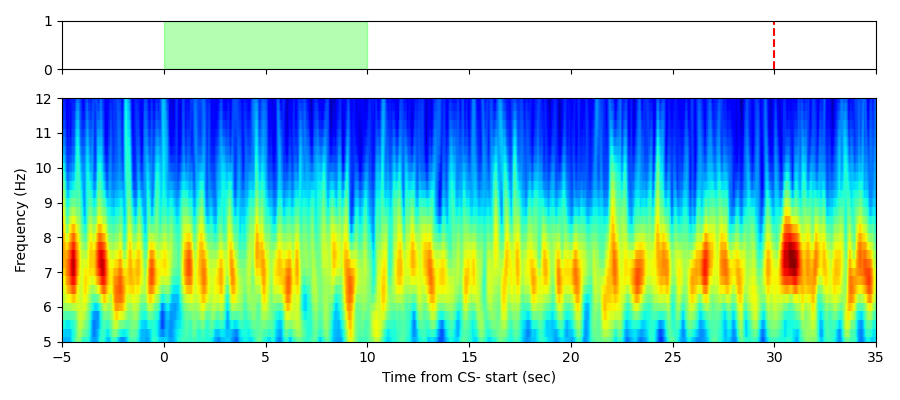

In [126]:
from tracefc.plotting.signals import plot_cs_mean_wavelet
cs_buffer = (5, 35)

# For recall sessions
if sess_name.find("recall") == 0:
    _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)
    _, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    plot_cs_mean_wavelet(wv_theta, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
    ax[5].set_title('CS+ at end of control tone recall session')

if sess_name.find("training") == 0: # for training sessions
    _, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)
    _, std_sxx = plot_cs_mean_wavelet(wv_theta, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    
elif sess_name.find("habituation") == 0: # For habituation sessions
    _, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[1, 5], layout='tight', sharex=True)

    plot_cs_mean_wavelet(wv_theta, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=theta_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=None, ax=ax[:2])

## Ripple mean spectrogram

interactive(children=(FloatSlider(value=6.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(1…

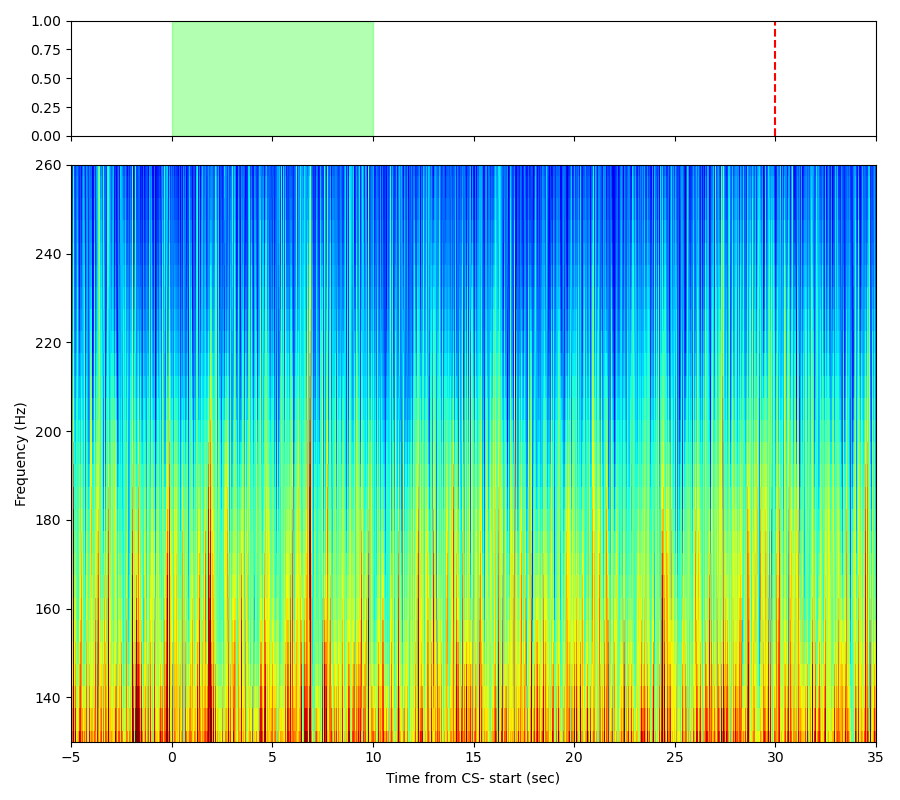

In [127]:
cs_buffer = (5, 35)

# For recall sessions
if sess_name.find("recall") == 0:
    _, ax = plt.subplots(6, 1, figsize=(9, 12), height_ratios=[1, 5, 1, 5, 1, 5], layout='tight', sharex=True)
    
    _, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    plot_cs_mean_wavelet(wv_swr, cs2_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[4:])
    ax[5].set_title('CS+ at end of control tone recall session')

elif sess_name.find("training") == 0:
    _, ax = plt.subplots(4, 1, figsize=(9, 8), height_ratios=[1, 5, 1, 5], layout='tight', sharex=True)
    
    _, std_sxx = plot_cs_mean_wavelet(wv_swr, cs_starts_combined, 'CS+', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, ax=ax[:2])
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=std_sxx, ax=ax[2:4])
    
elif sess_name.find("habituation") == 0: # For habituation sessions
    _, ax = plt.subplots(2, 1, figsize=(9, 8), height_ratios=[1, 5], layout='tight', sharex=True)
    plot_cs_mean_wavelet(wv_swr, csn_starts_combined, 'CS-', buffer_sec=cs_buffer, freq_lims=swr_freq_lims,
                         ignore_epochs=art_epochs, std_sxx=None, ax=ax[:2])

## Save notebook to working directory

In [128]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{animal}_{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Spectral_Analysis.ipynb saved to /data3/Trace_FC/Recording_Rats/Finn2/2023_05_06_habituation1/Finn2_habituation1_Spectral_Analysis.ipynb
